# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

The tools you have are **color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.**  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [2]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


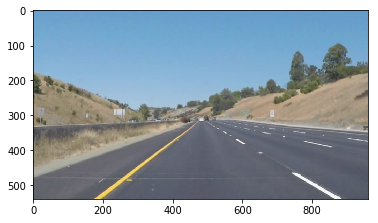

In [3]:
#reading in an image
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [4]:
import math
class Queue:
    """
    Define a queue class for smoothing the slope and bias of the lane line.
    Smoothing is necessary for this task. 
    """
    def __init__(self):
        self.items = []

    def isEmpty(self):
        return self.items == []
    
    def Empty(self):
        while self.isEmpty() == False:
            self.items.get()
        return self.items
    
    def put(self, item):
        self.items.insert(0,item)
        
    def avg(self):
        return np.mean(self.items)

    def get(self):
        return self.items.pop()

    def size(self):
        return len(self.items)
    
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    通过建造堆栈减小划线的震动，每词划线的m和b应为前十个窗口的平均值
    """  
#     for line in lines:
#         for x1,y1,x2,y2 in line:
#             cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    left_lane_lines_x = []
    left_lane_lines_y = []
    right_lane_lines_x = []
    right_lane_lines_y = []
    left_q_m = Queue()
    right_q_m = Queue()
    left_q_b = Queue()
    right_q_b = Queue()
    
    x_size = img.shape[1]
    y_size = img.shape[0]
    for line in lines:
        for x1,y1,x2,y2 in line:
            if abs(x1-x2) == 0:
                slope = float("inf")
            else:
                slope = (y2 - y1)/(x2 - x1)

            if slope > 0.5 and x1 > x_size/2 and x2 > x_size/2: #选择在图片右边且斜率>0.5的直线
                right_lane_lines_x.append(x1)
                right_lane_lines_x.append(x2)
                right_lane_lines_y.append(y1)
                right_lane_lines_y.append(y2)
            elif slope < -0.5 and x1 < x_size/2 and x2 < x_size/2: #选择在图片左边且斜率<-0.5的直线
                left_lane_lines_x.append(x1)
                left_lane_lines_x.append(x2)
                left_lane_lines_y.append(y1)
                left_lane_lines_y.append(y2)
            
    right_exist = False
    left_exist = False
    if right_lane_lines_x != [] and right_lane_lines_y!= []:
        r_m, r_b = np.polyfit(right_lane_lines_x, right_lane_lines_y, 1)
        right_exist = True
        
    if left_lane_lines_x != [] and left_lane_lines_y!= []:
        l_m, l_b = np.polyfit(left_lane_lines_x, left_lane_lines_y, 1)
        left_exist = True
    
    # Smoothing the slope and bias to make the lane line detection roust.
    if left_exist:
        if left_q_m.size() < 30:
            left_q_m.put(l_m)
        else:
            left_q_m.get()
            left_q_m.put(l_m)

        if left_q_b.size() < 30:
            left_q_b.put(l_b)
        else:
            left_q_b.get()
            left_q_b.put(l_b)
            
    if right_exist:      
        if right_q_m.size() < 30:
            right_q_m.put(r_m)
        else:
            right_q_m.get()
            right_q_m.put(r_m)

        if right_q_b.size() < 30:
            right_q_b.put(r_b)
        else:
            right_q_b.get()
            right_q_b.put(r_b)
    
    m_r = right_q_m.avg()
    b_r = right_q_b.avg()
    m_l = left_q_m.avg()
    b_l = left_q_b.avg()
    
    y1 = img.shape[0] 
    y2 = img.shape[0] * (1 - 0.39)  #控制划线范围

    r_x1 = (y1 - b_r) / m_r
    r_x2 = (y2 - b_r) / m_r

    l_x1 = (y1 - b_l) / m_l
    l_x2 = (y2 - b_l) / m_l

    cv2.line(img, (int(r_x1), y1), (int(r_x2), int(y2)), color, thickness)
    cv2.line(img, (int(l_x1), y1), (int(l_x2), int(y2)), color, thickness)

In [5]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def yellow_enhance(img_rgb):
    '''
    该函数将rgb中淡黄色转换成白色，主要分三步：
    step1:convert rgb to hsv
    step2:create a lower/upper range of hsv
    step3:create a mask
    '''
    img_hsv = cv2.cvtColor(img_rgb,cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([40,100,20])
    upper_yellow = np.array([100,255,255])
    mask = cv2.inRange(img_hsv,lower_yellow,upper_yellow)
    gray = grayscale(img_rgb)
    return weighted_img(mask,gray,1.,1.,0.)


def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask) #与操作，0与任何都为0, 1(255)与其他变为其他
    return masked_image


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ 两张图的加权融合
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

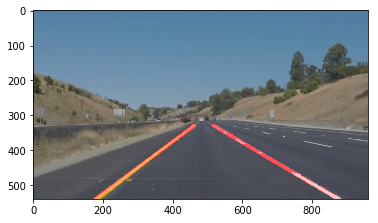

In [12]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
gray_image = yellow_enhance(image)
edges = canny(gaussian_blur(gray_image, kernel_size=7), low_threshold=50, high_threshold=150)
plt.imshow(edges, cmap='Greys_r')

imshape = image.shape
vertices = np.array([[(imshape[1]*0.15,imshape[0]*0.95),(imshape[1]*0.47, imshape[0]*0.6), 
                       (imshape[1]*0.53, imshape[0]*0.6), (imshape[1]*0.9,imshape[0]*0.95)]], dtype=np.int32)
masked_edges = region_of_interest(edges, vertices)
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15  # minimum number of votes (intersections in Hough grid cell)
min_line_len = 5 #minimum number of pixels making up a line
max_line_gap = 25  # maximum gap in pixels between connectable line segments
# line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
line_img = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)

final_img = weighted_img(line_img, image)
plt.imshow(final_img)


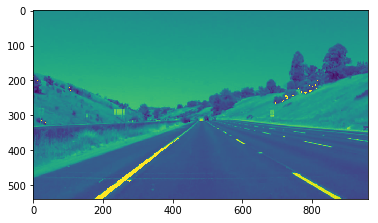

In [13]:
plt.imshow(gray_image)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [14]:
def process_image(image):
    gray_image = grayscale(image)
    edges = canny(gaussian_blur(gray_image, kernel_size=7), low_threshold=50, high_threshold=150)

    imshape = image.shape
    vertices = np.array([[(imshape[1]*0.15,imshape[0]*0.95),(imshape[1]*0.47, imshape[0]*0.6), 
                       (imshape[1]*0.53, imshape[0]*0.6), (imshape[1]*0.9,imshape[0]*0.95)]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15  # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 10 #minimum number of pixels making up a line
    max_line_gap = 25  # maximum gap in pixels between connectable line segments
    # line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    line_img = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)

    result = weighted_img(line_img, image)

    return result

Let's try the one with the solid white lane on the right first ...

In [15]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:03<00:00, 57.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 4.27 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))